# Percobaan Time Series Forecasting dengan RNN

Mengimpor library dan Memeriksa Versi Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


Membuat Bentuk Fungsi Data Series

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Waktu")
    plt.ylabel("Nilai")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

#Membuat Series
series = baseline + trend(time, slope) + seasonality(time, 
                                                     period=365, 
                                                     amplitude=amplitude)
#Menambahkan Noise
series += noise(time, noise_level, seed=42)

Membagi Dataset

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Memvisualisasikan Data

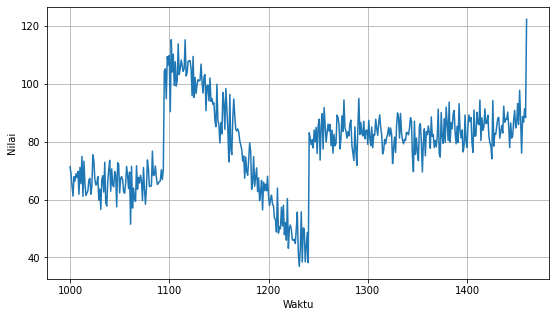

In [ ]:
plt.figure(figsize=(9, 5))
plot_series(time_valid, x_valid)

Membuat Windowed Dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], 
                                                                window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Membuat Model dengan RNN

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#Memanggil Fungsi Windowed Dataset
train_set = windowed_dataset(x_train, window_size, batch_size=128, 
                             shuffle_buffer=shuffle_buffer_size)
#Membuat Sequential Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]), #Membuat Lambda Layer
  #Membuat RNN Layer
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1), #Membuat Dense Layer
  tf.keras.layers.Lambda(lambda x: x * 100.0) #Membuat Lambda Layer
])

#Membuat Callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, 
                                    momentum=0.9)
#Mengcompile Model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Mentraining Model

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 19ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 191.9081 - mae: 192.4081
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 185.3787 - mae: 185.8787
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [===========

Membuat Visualisasi Prediksi

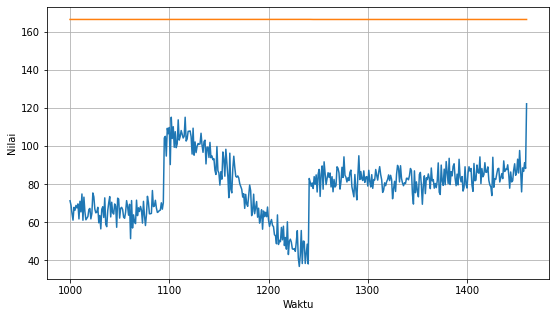

In [ ]:
prediksi = []
for time in range(len(series) - window_size):
  prediksi.append(model.predict(series[time:time + window_size]
                                [np.newaxis]))

prediksi = prediksi[split_time-window_size:]
hasil = np.array(prediksi)[:, 0, 0]


plt.figure(figsize=(9, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, hasil)

Mengukur Hasil MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, hasil).numpy()

88.18091

# Memperbaiki Model

Mencari Nilai Optimum Learning Rate

(1e-08, 0.0001, 0.0, 30.0)

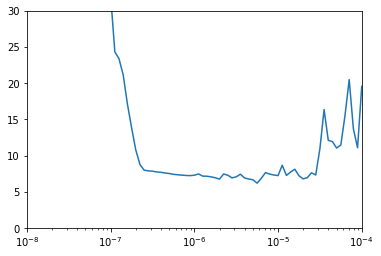

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

Membuat Model Baru

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, 
                           shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=6e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Mentraining Model

In [ ]:
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 13ms/step - loss: 85.9672 - mae: 86.4656
Epoch 2/400
8/8 [==============================] - 0s 14ms/step - loss: 22.4703 - mae: 22.9655
Epoch 3/400
8/8 [==============================] - 0s 13ms/step - loss: 17.3302 - mae: 17.8200
Epoch 4/400
8/8 [==============================] - 0s 14ms/step - loss: 13.4548 - mae: 13.9470
Epoch 5/400
8/8 [==============================] - 0s 13ms/step - loss: 10.9661 - mae: 11.4544
Epoch 6/400
8/8 [==============================] - 0s 13ms/step - loss: 11.6408 - mae: 12.1324
Epoch 7/400
8/8 [==============================] - 0s 13ms/step - loss: 18.4636 - mae: 18.9591
Epoch 8/400
8/8 [==============================] - 0s 14ms/step - loss: 13.6113 - mae: 14.1049
Epoch 9/400
8/8 [==============================] - 0s 14ms/step - loss: 10.6281 - mae: 11.1222
Epoch 10/400
8/8 [==============================] - 0s 12ms/step - loss: 8.5276 - mae: 9.0144
Epoch 11/400
8/8 [==============================] -

Memvisualisasikan Hasil Prediksi

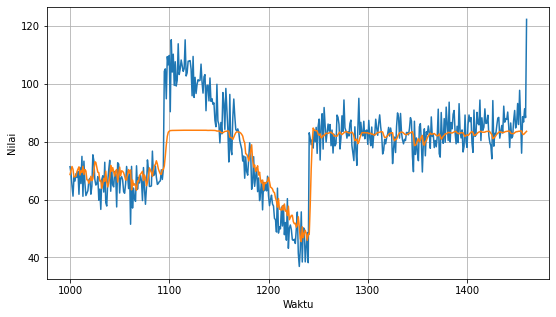

In [ ]:
prediksi=[]
for time in range(len(series) - window_size):
  prediksi.append(model.predict(series[time:time + window_size]
                                [np.newaxis]))

prediksi = prediksi[split_time-window_size:]
hasil = np.array(prediksi)[:, 0, 0]


plt.figure(figsize=(9, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, hasil)

Menghitung Hasil MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, hasil).numpy()

6.4636235